In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
df_embassy = pd.read_csv("../data/ulaanbaatar-us embassy-air-quality.csv")
df_naran = pd.read_csv("../data/urgakh-naran-air-quality.csv")
df_100 = pd.read_csv("../data/100-ail-air-quality.csv")
df_misheel = pd.read_csv("../data/misheel-expo-air-quality.csv")

In [43]:
df_misheel.columns

Index(['date', ' pm25', ' pm10', ' o3', ' no2', ' so2', ' co'], dtype='object')

In [44]:
dataframes = [df_embassy, df_naran, df_100, df_misheel]

#Location names
locations = ['US Embassy', 'Naran Mall', '100 Ail', 'Misheel Expo'] 
#Pollutant names
pollutants = [' pm25', ' pm10', ' o3', ' no2', ' so2', ' co']

In [45]:
def data_cleaner(df):
    #Change empty data into Nan
    df = df.replace(to_replace = " ", value=np.nan)
    #Change dates to same format
    df['date'] = pd.to_datetime(df['date'])
    #Sort by date
    df = df.sort_values('date').reset_index(drop=True)
    #Remove rows with only date data
    df = df.dropna(subset=pollutants, how='all')
    # Convert to numeric and coerce invalid strings to NaN
    for col in pollutants:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    #Fill in the empty row data with rolling median
    for col in pollutants:
        df[col] = df[col].fillna(df[col].rolling(window=7, min_periods=2).median())
        #Find unusual spikes (10x the mean in two weeks rolling) which might indicate inaccurate data
        threshold = df[col].rolling(7).mean() * 5  
        df.loc[df[col] > threshold, col] = np.nan
    
    return df

In [46]:
cleaned_dfs = []
for df in dataframes:
    df_clean = data_cleaner(df)
    cleaned_dfs.append(df_clean)

In [47]:
cleaned_dfs[1].head(10)

,date,pm25,pm10,o3,no2,so2,co
0,2014-09-15,NaN,NaN,NaN,12.0,3.0,3.0
1,2014-09-16,NaN,69.0,14.0,5.0,5.0,3.0
2,2014-09-17,NaN,53.0,NaN,8.5,4.0,3.0
3,2014-10-22,NaN,61.0,10.0,7.0,2.0,1.0
4,2014-10-23,NaN,3.0,15.0,9.0,12.0,3.0
5,2014-10-24,NaN,4.0,14.0,8.0,4.0,3.0
6,2014-11-02,NaN,28.5,5.0,24.0,12.0,4.0
7,2014-11-03,NaN,109.0,2.0,27.0,10.0,9.0
8,2014-11-04,NaN,126.0,7.5,16.5,11.0,3.5
9,2014-11-09,NaN,56.5,7.0,10.0,1.0,3.0


In [48]:
combined = []

for i, df in enumerate(cleaned_dfs):
    df = df.copy()
    location_name = locations[i] if i < len(locations) else f'Location {i+1}'
    df['location'] = location_name
    combined.append(df)

# Merge all into one DataFrame
df_all = pd.concat(combined, ignore_index=True)

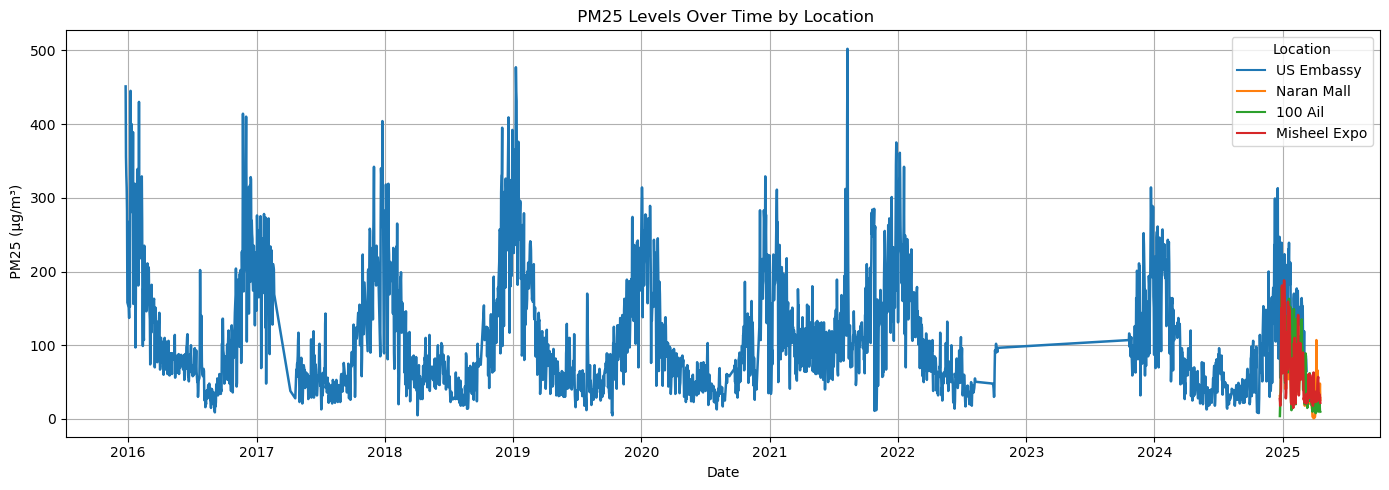

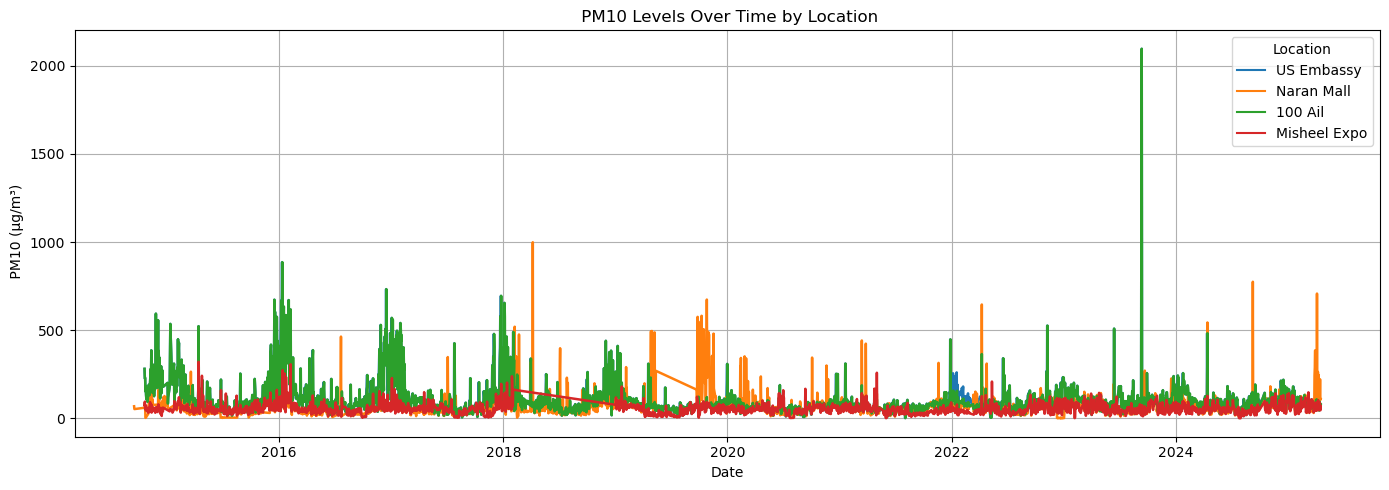

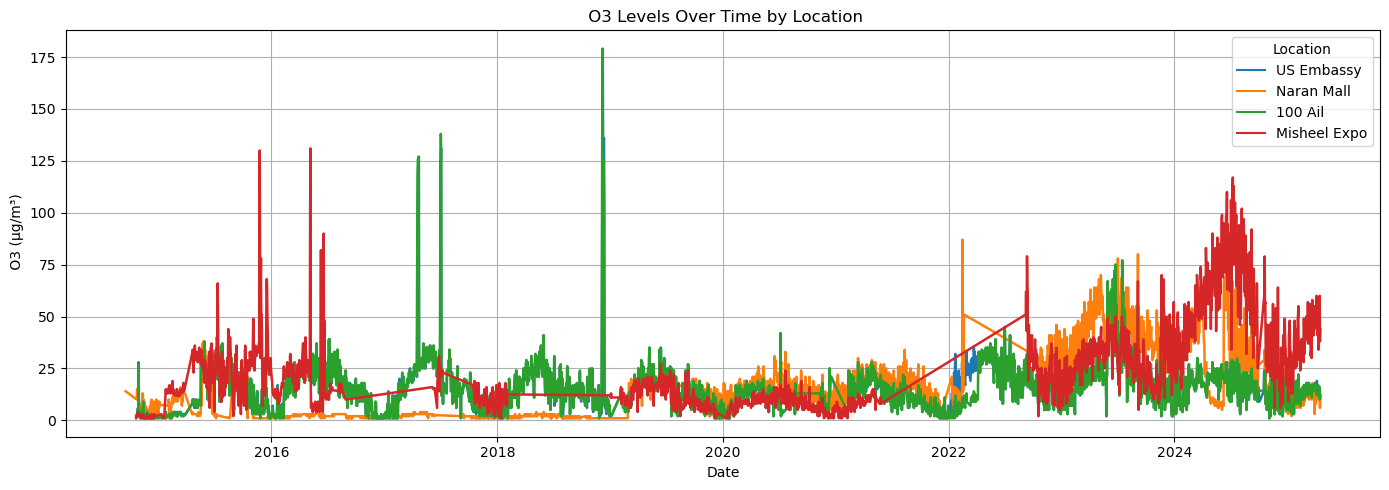

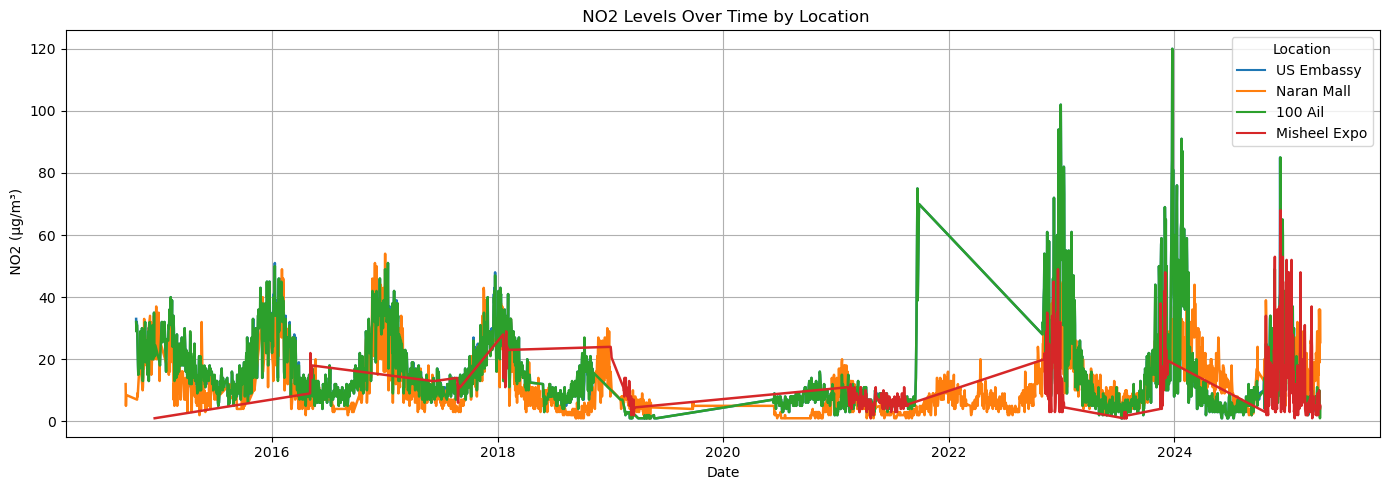

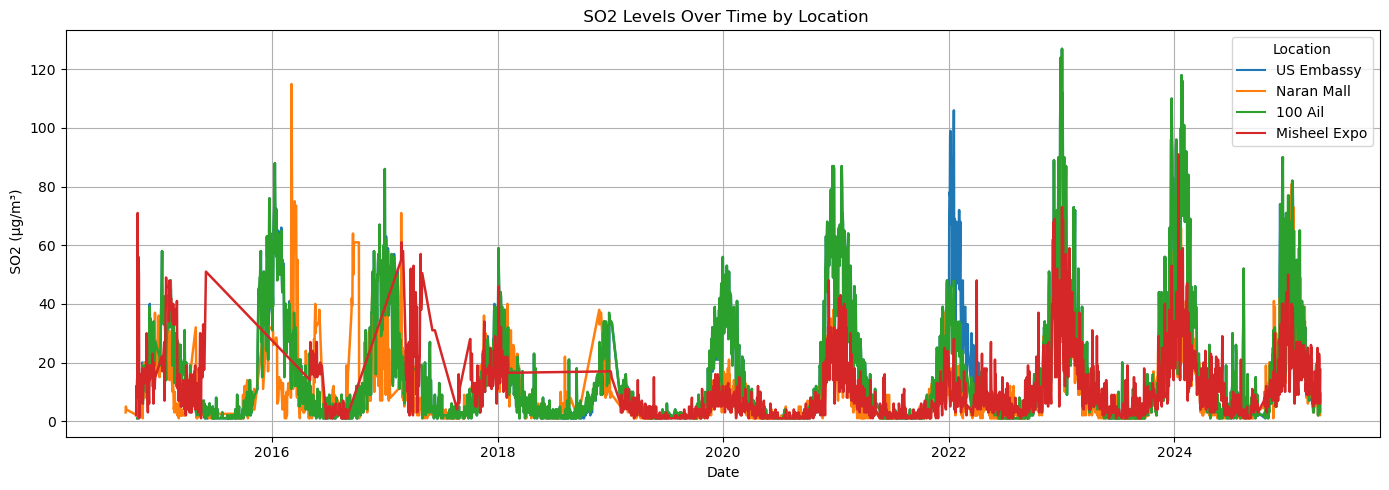

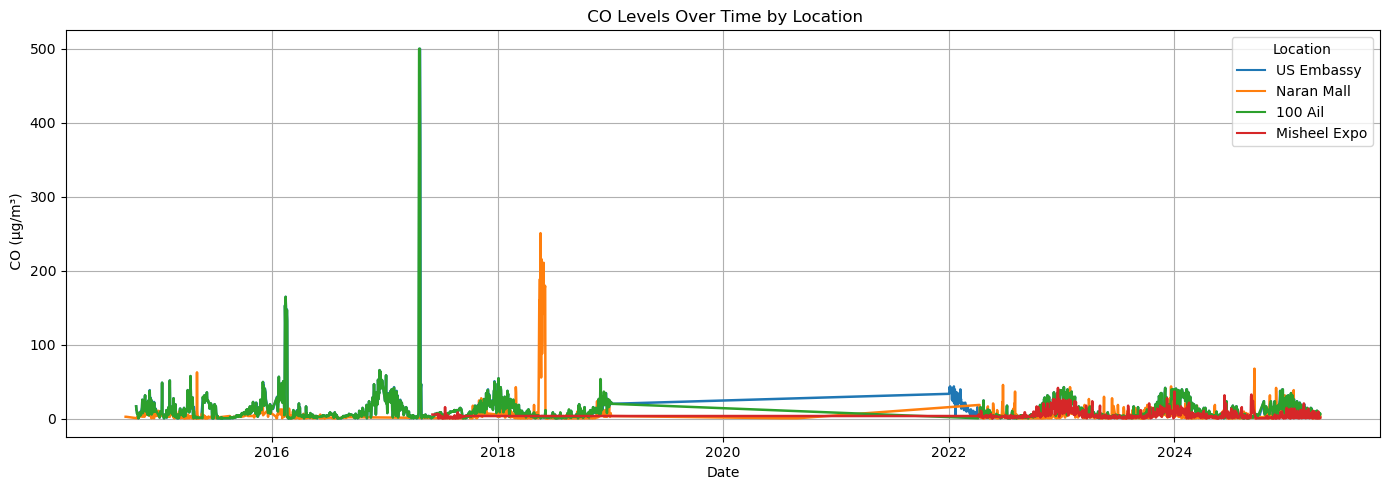

In [49]:
for pollutant in pollutants:
    if pollutant in df_all.columns:
        plt.figure(figsize=(14, 5))
        sns.lineplot(data=df_all, x='date', y=pollutant, hue='location', linewidth=1.8)
        plt.title(f'{pollutant.upper()} Levels Over Time by Location')
        plt.xlabel('Date')
        plt.ylabel(f'{pollutant.upper()} (μg/m³)')
        plt.legend(title='Location')
        plt.grid(True)
        plt.tight_layout()
        plt.show()